In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import candas as can
import gumbi as gmb
from candas.lims import Librarian, library
from candas.learn import ParameterSet

base_pth, code_pth, data_pth, rslt_pth, fig_pth = can.utils.setup_paths(make_missing=False)
plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
ps = ParameterSet.load(data_pth / 'ADVI_ParameterSets_220528.pkl')
data = (ps.wide
        .query('Metric == "mean"')
        .astype({'BP': float})
        .groupby(['Target','Reporter'])
        .mean()
        .reset_index()
        )

ds = gmb.DataSet(
    data = data,
    outputs = ['F0_lg', 'r', 'K', 'm'],
    log_vars = ['BP', 'K', 'm', 'r'],
    logit_vars = ['GC'],
    )

# Average

In [3]:
recalculate = False

if recalculate:
    gp = gmb.GP(ds).fit(
        # outputs='m',
        continuous_dims=['BP', 'GC'],
        categorical_dims=['Reporter'],
        )

    with open(rslt_pth / 'Model_Avg.pkl', 'wb') as f:
        dill.dump(gp, f)
else:
    with open(rslt_pth / 'Model_Avg.pkl', 'rb') as f:
        gp = dill.load(f)

In [4]:
predictions_dict = {}

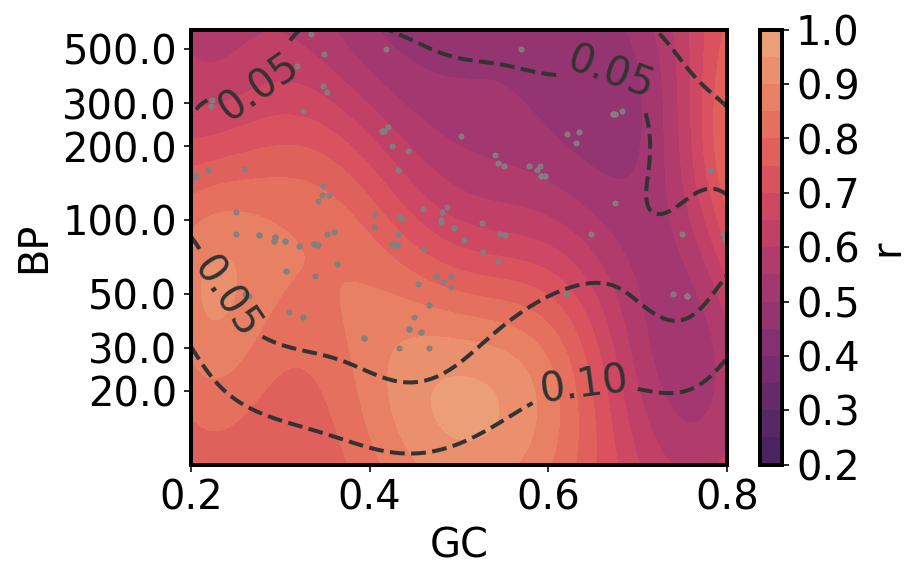

In [5]:
output = 'r'
reporter = 'HEX'

limits = gp.parray(GC=[0.2, 0.8], BP=[10, 600])
XY = gp.prepare_grid(limits=limits)
r = gp.predict_grid(
    output=output,
    with_noise=False,
    categorical_levels={'Reporter': reporter}
)
BP, GC = XY['BP'], XY['GC']

predictions_dict['r'] = r
predictions_dict['BP'] = BP
predictions_dict['GC'] = GC

pp = gmb.ParrayPlotter(x=GC, y=BP, z=r, 
                    #    x_scale='standardized',
                       y_scale='standardized'
                       )

cmap=sns.color_palette('flare_r', as_cmap=True)
# rnorm = mpl.colors.Normalize()
# rnorm(r.μ)
rnorm = mpl.colors.Normalize(vmin=0.23, vmax=1.03)

cs = pp(plt.contourf, levels=np.arange(0.20, 1.05, 0.05), cmap='flare_r', norm=rnorm)
pp.colorbar(cs)

ax=plt.gca()

yticks = gp.parray(BP=[20, 30, 50, 100, 200, 300, 500])
ax.set_yticks(yticks['BP'].z.values())
ax.set_yticklabels(yticks.values())

gc = (ds.wide
      .query('Reporter == @reporter')
      .GC
     )
bp = (ds.wide.z
      .query('Reporter == @reporter')
      .BP
     )

ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=1)

ax.set_xlim(limits['GC'].values())

cs = ax.contour(GC.values(), BP.z.values(), r.σ, levels=[0.05, 0.10, 0.15, 0.20, 0.25], colors='0.2', linestyles='--')
ax.clabel(cs);

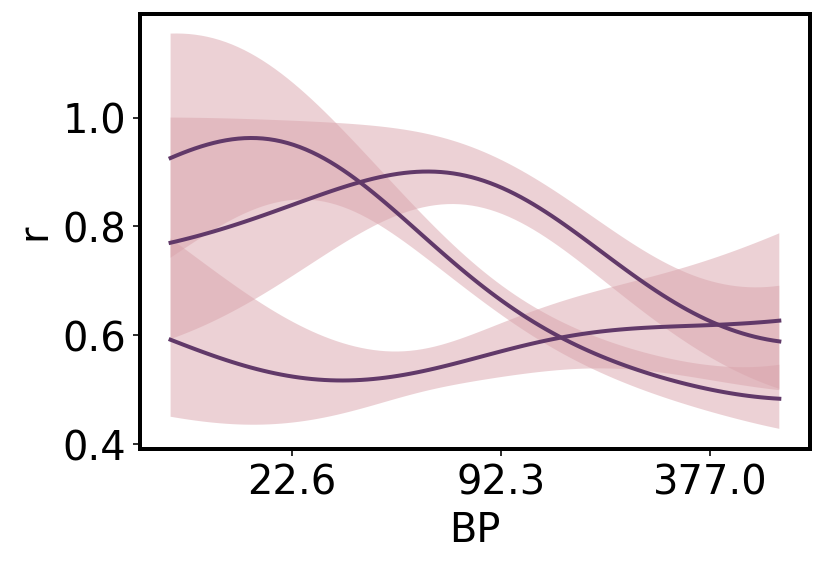

In [6]:
for gc in [0.25, 0.5, 0.75]:
    x_pa, y_upa = gp.get_conditional_prediction(GC=gc)
    gmb.ParrayPlotter(x_pa.z, y_upa).plot()
    predictions_dict[f'GC {gc:.2f}'] = [x_pa, y_upa]

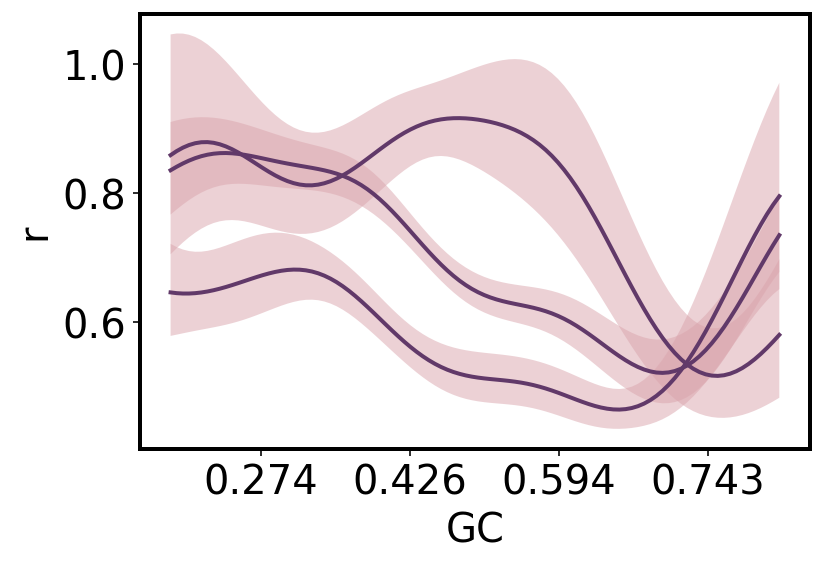

In [7]:
for bp in [30, 100, 300]:
    x_pa, y_upa = gp.get_conditional_prediction(BP=bp)
    gmb.ParrayPlotter(x_pa.z, y_upa).plot()
    predictions_dict[f'BP {bp}'] = [x_pa, y_upa]

In [8]:
## Dill needs to "warm up" for some reason??

for value in predictions_dict.values():
    dump = dill.dumps(value)
    loaded = dill.loads(dump)

In [10]:
with open(rslt_pth / 'Model_Avg_predictions.pkl', 'wb') as f:
    dill.dump(predictions_dict, f)
    
with open(rslt_pth / 'Model_Avg_predictions.pkl', 'rb') as f:
    loaded = dill.load(f)
    
loaded

{'r': r['μ', 'σ2']: [[(0.76506605, 0.02053206) (0.76778959, 0.02024058)
   (0.77061876, 0.0199374 ) ... (0.5936056 , 0.0087741 )
   (0.59239313, 0.00926901) (0.59146714, 0.00977356)]
  [(0.76759383, 0.02025802) (0.77042949, 0.01994805)
   (0.7733743 , 0.01962602) ... (0.59069429, 0.00831915)
   (0.58942879, 0.0088108 ) (0.58845708, 0.00931334)]
  [(0.76974323, 0.01998146) (0.77266744, 0.0196526 )
   (0.77570359, 0.01931131) ... (0.58848003, 0.00791688)
   (0.58715706, 0.0084034 ) (0.58613408, 0.00890194)]
  ...
  [(0.60101259, 0.0209669 ) (0.59725805, 0.02060914)
   (0.59358274, 0.02023294) ... (0.74217719, 0.01687451)
   (0.74032739, 0.01733224) (0.73852349, 0.01777879)]
  [(0.60562652, 0.02122743) (0.60204844, 0.02088808)
   (0.5985516 , 0.02053076) ... (0.75281896, 0.01728773)
   (0.75067664, 0.01773637) (0.74858044, 0.01817294)]
  [(0.61075136, 0.02149258) (0.60736269, 0.02117202)
   (0.60405677, 0.02083398) ... (0.76226873, 0.01768921)
   (0.75986566, 0.01812746) (0.75750928, 0.01